volume shape = (201, 201, 61)
ny = 201, nx = 201, nz = 61 (จำนวน slice)


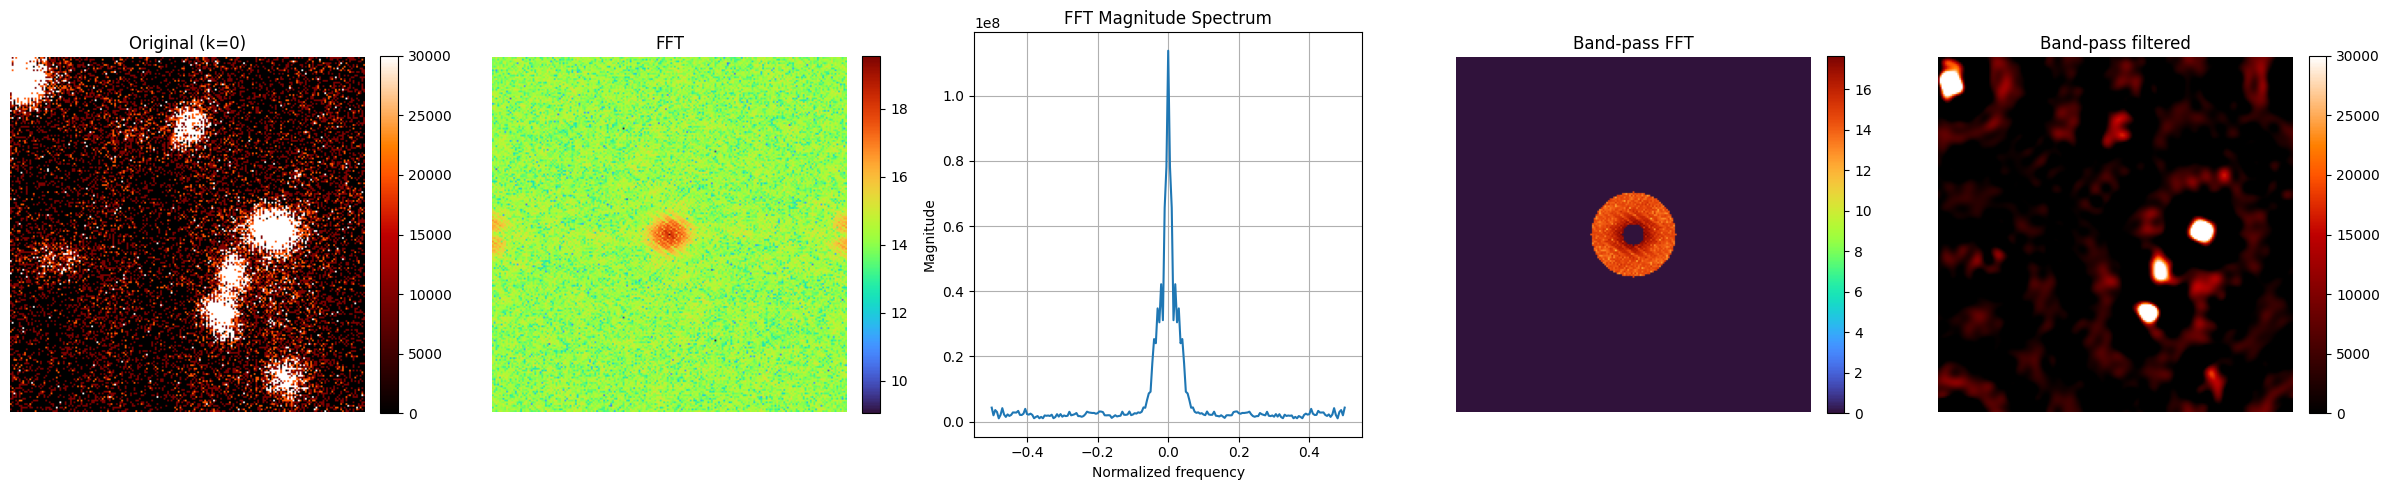

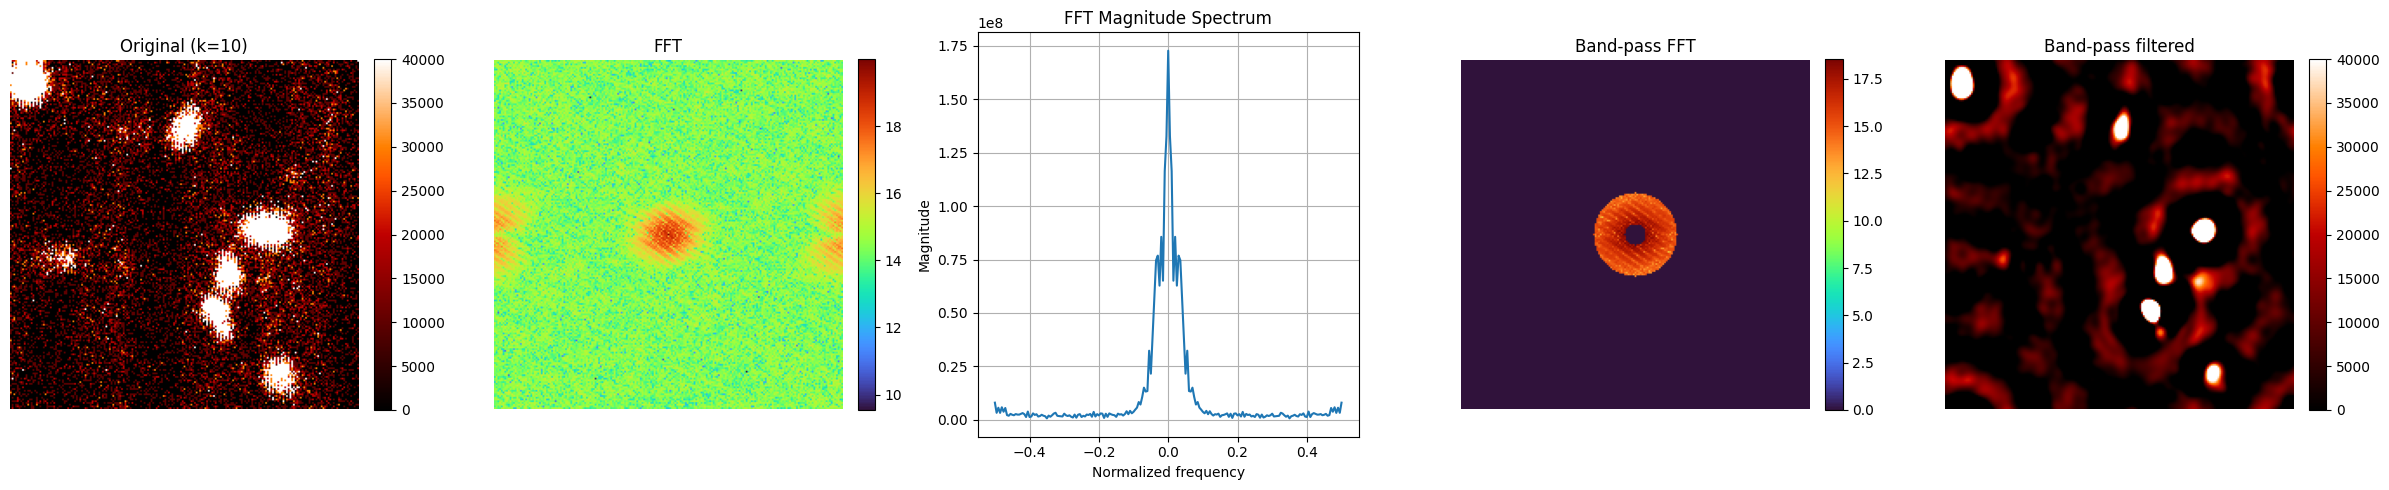

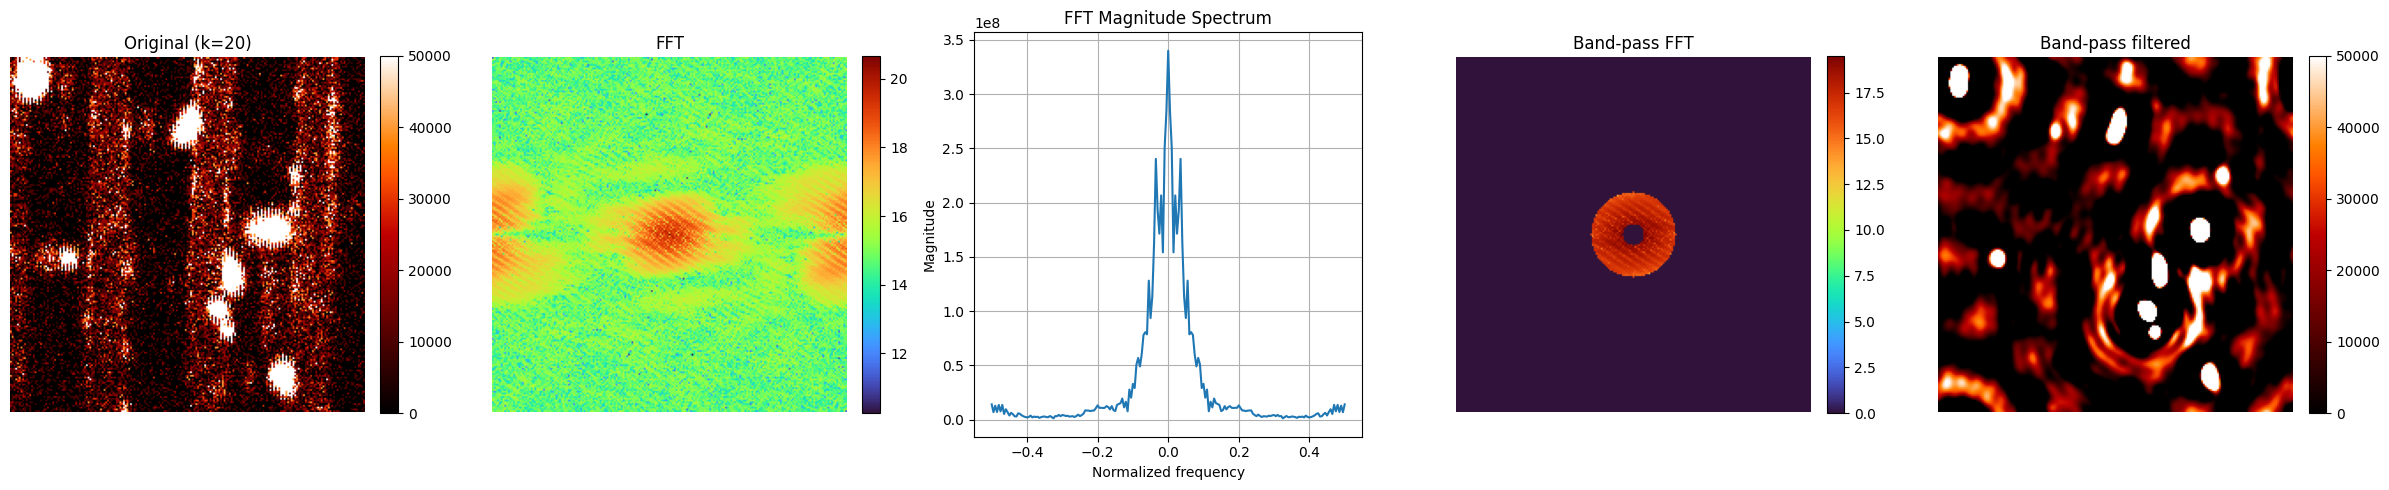

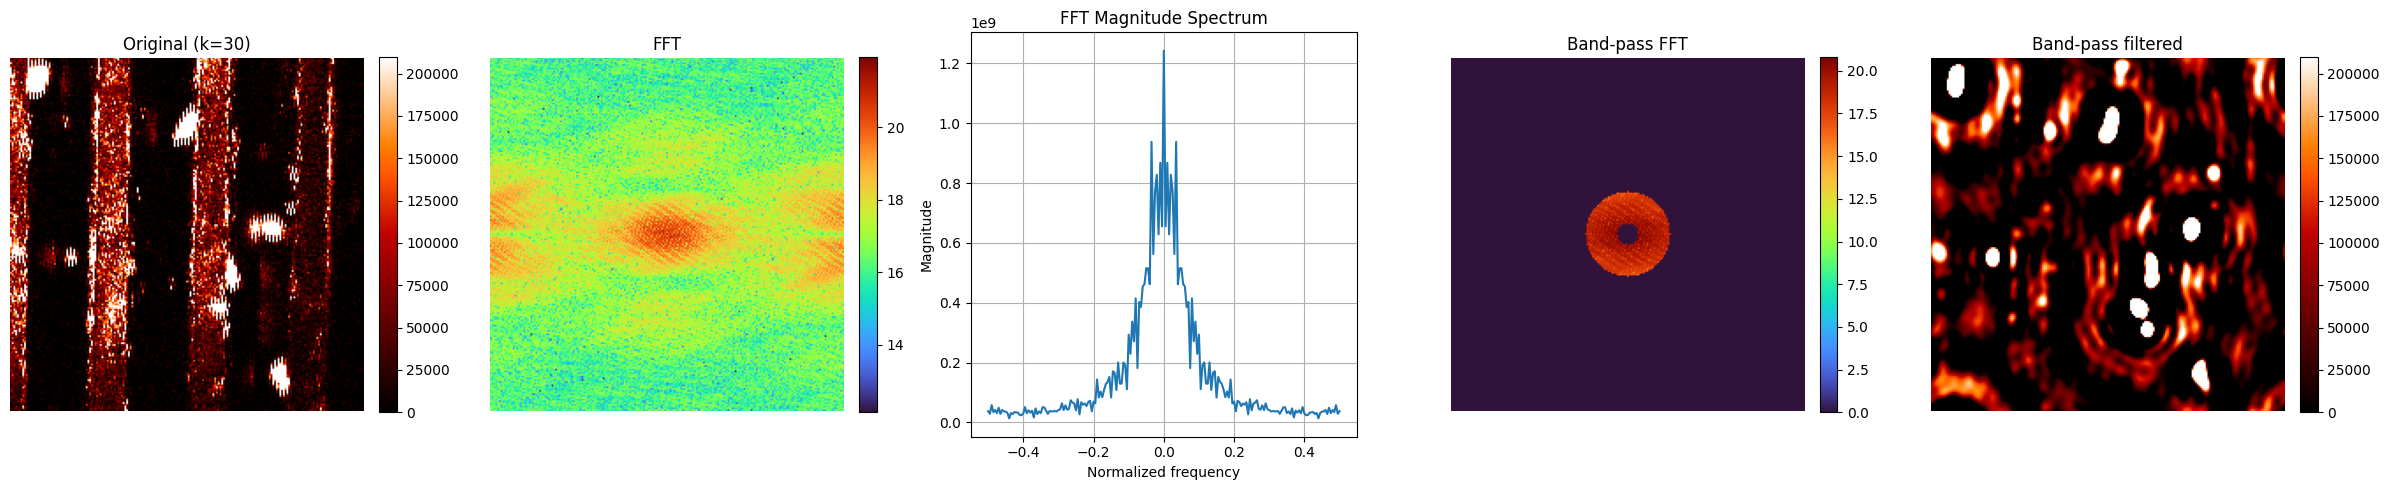

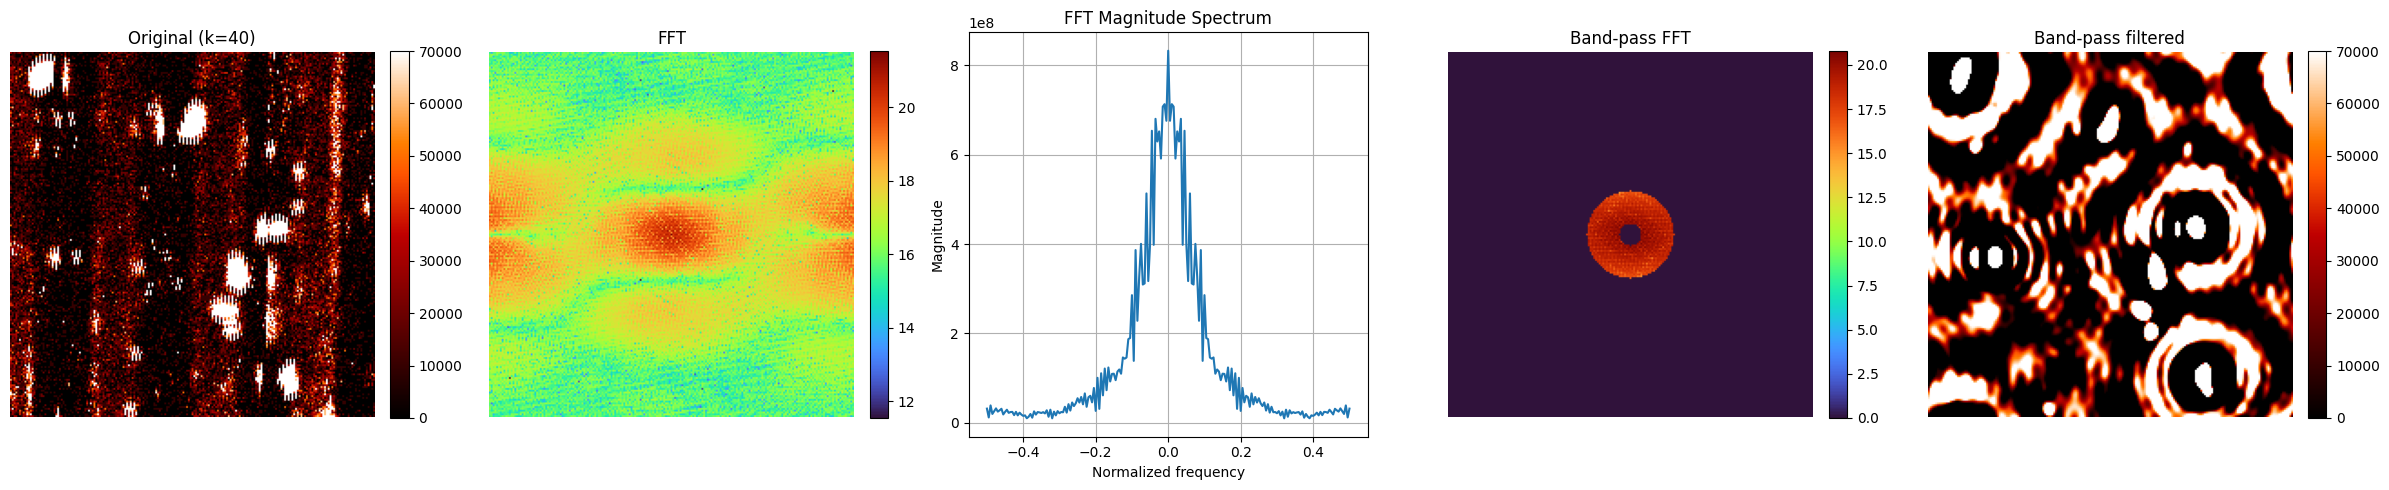

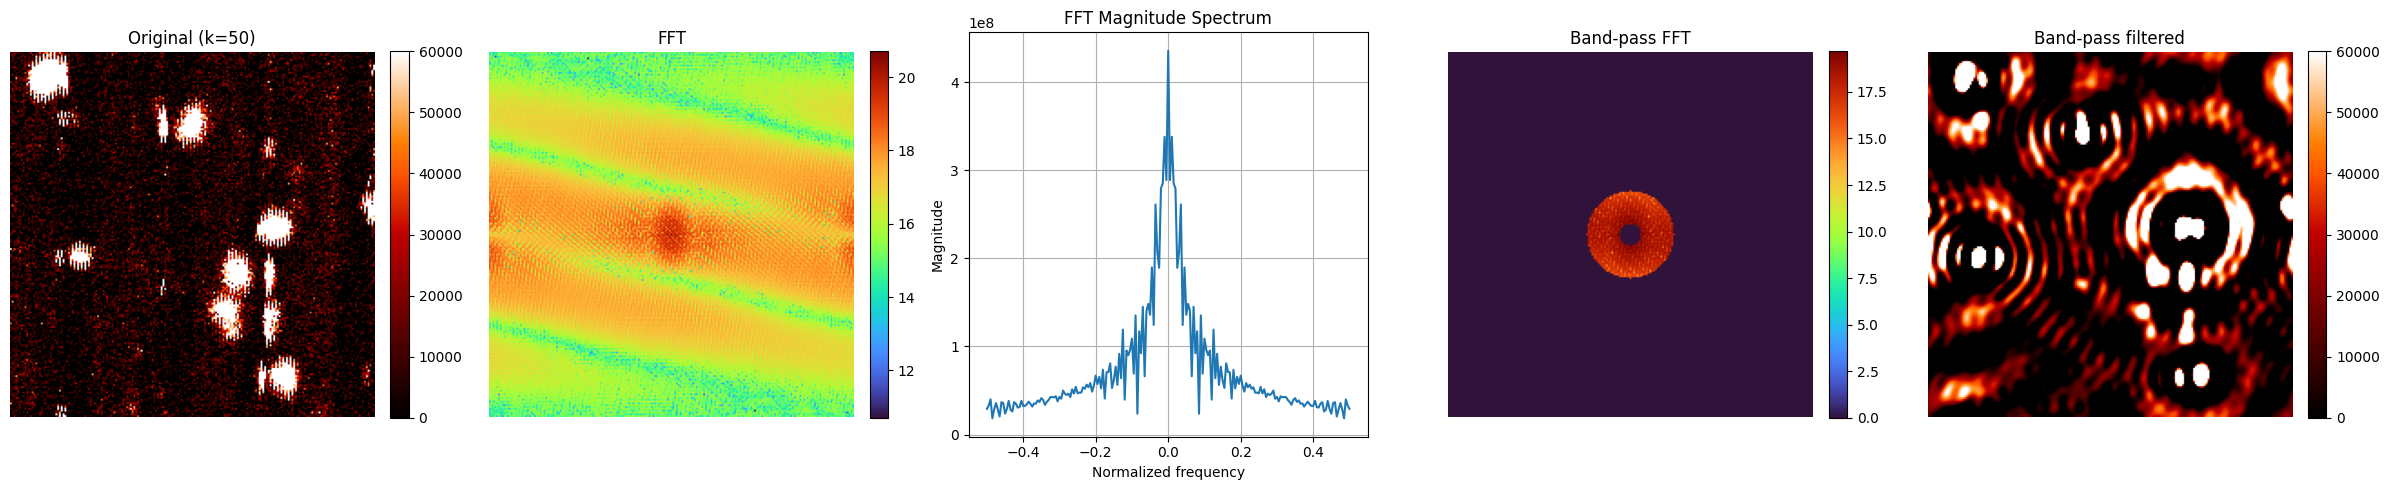

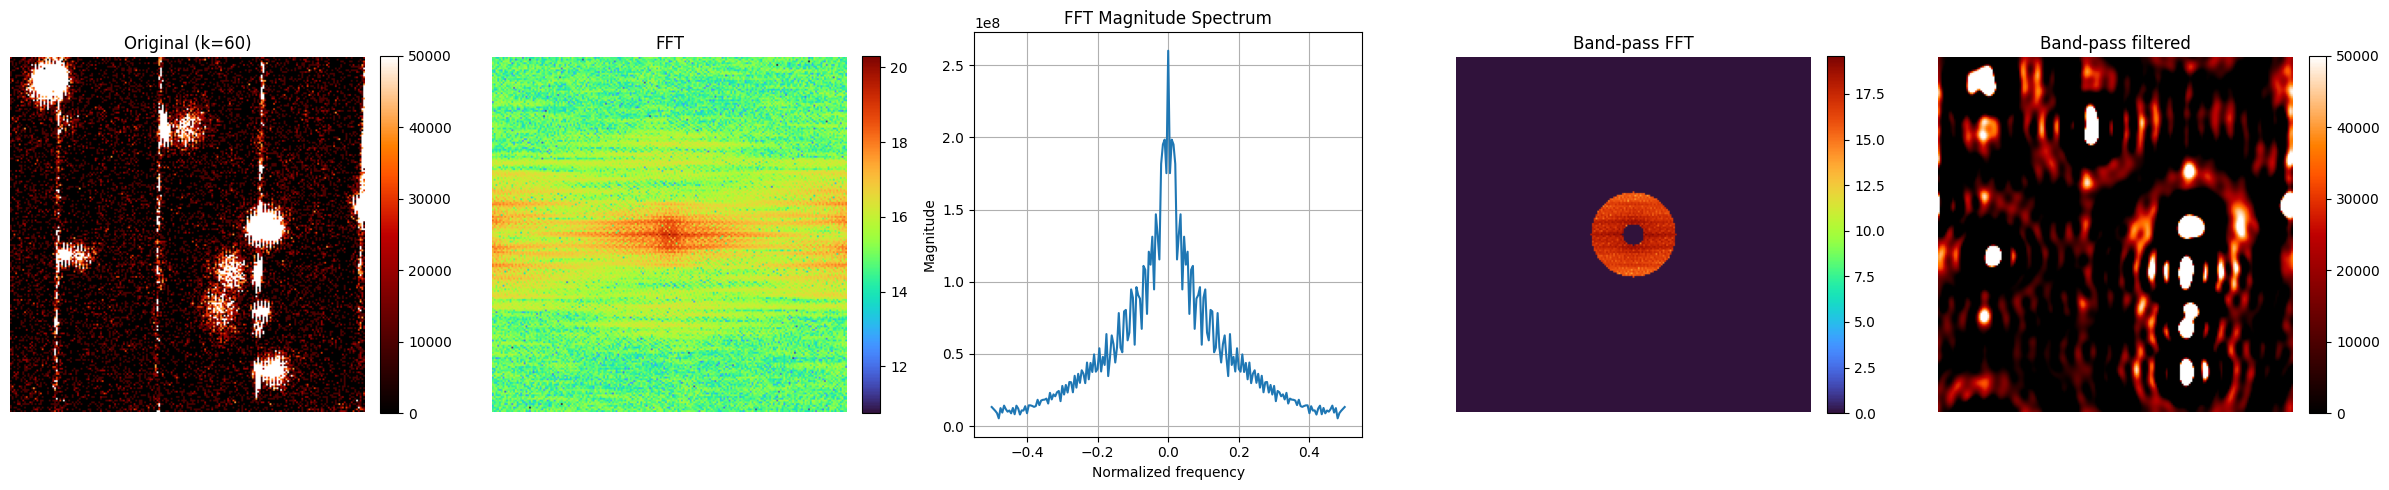

In [13]:
# =========================================
# Import
# =========================================
try:
    import scipy.io as sio
except ImportError:
    import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline


# =========================================
# 1) Load .mat file (3D volume)
# =========================================
file_path = 'IMG_0191.mat'   # <-- แก้ชื่อไฟล์ได้
varname   = 'pl'             # <-- ชื่อตัวแปรใน .mat

mat = sio.loadmat(file_path)

if varname not in mat:
    raise KeyError(f"ตัวแปร '{varname}' ไม่มีในไฟล์ {file_path}")

vol = mat[varname]
print('volume shape =', vol.shape)

if vol.ndim != 3:
    raise ValueError(f'คาดว่าเป็น 3D volume (ny, nx, nz) แต่ได้ shape = {vol.shape}')

ny, nx, nz = vol.shape
print(f'ny = {ny}, nx = {nx}, nz = {nz} (จำนวน slice)')


# =========================================
# 2) FFT ของทั้ง volume
# =========================================
fft_vol = np.zeros((ny, nx, nz), dtype=complex)

for k in range(nz):
    fft_vol[:, :, k] = np.fft.fftshift(
        np.fft.fft2(vol[:, :, k])
    )


# =========================================
# 3) สร้าง Band-pass mask (2D)
# =========================================
fy = np.linspace(-0.5, 0.5, ny)
fx = np.linspace(-0.5, 0.5, nx)
FX, FY = np.meshgrid(fx, fy)
D = np.sqrt(FX**2 + FY**2)

# ---- ปรับตาม spatial frequency ของ stripe ----
low_cut  = 0.03
high_cut = 0.12

bandpass_mask = (D >= low_cut) & (D <= high_cut)


# =========================================
# 4) Apply Band-pass + Inverse FFT
# =========================================
fft_bp = np.zeros_like(fft_vol, dtype=complex)
img_bp = np.zeros_like(vol, dtype=float)

for k in range(nz):
    fft_bp[:, :, k] = fft_vol[:, :, k] * bandpass_mask
    img_bp[:, :, k] = np.real(
        np.fft.ifft2(np.fft.ifftshift(fft_bp[:, :, k]))
    )


# =========================================
# 5) Frequency axis for spectrum plot
# =========================================
freq_x = np.linspace(-0.5, 0.5, nx)


# =========================================
# 6) Visualization function
# =========================================
def show_slice_bandpass(
    k,
    vmin=None,
    vmax=None,
    cmap_img='gist_heat',
    cmap_fft='turbo',
    cmap_filt='gist_heat'
):
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    img  = vol[:, :, k]
    F    = fft_vol[:, :, k]
    Fbp  = fft_bp[:, :, k]
    imgf = img_bp[:, :, k]

    logF   = np.log1p(np.abs(F))
    logFbp = np.log1p(np.abs(Fbp))

    # ---- auto contrast ----
    if vmin is None:
        vmin = np.percentile(img, 2)
    if vmax is None:
        vmax = np.percentile(img, 95)

    # ---- FFT spectrum (1D) ----
    mag = np.abs(F)
    cy = ny // 2

    # average 3 rows around center to reduce noise
    spectrum = mag[cy-1:cy+2, :].mean(axis=0)

    fig, axes = plt.subplots(1, 5, figsize=(24, 5))

    # 1. Original
    im0 = axes[0].imshow(img, cmap=cmap_img, origin='lower',
                         vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original (k={k})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 2. FFT
    im1 = axes[1].imshow(logF, cmap=cmap_fft, origin='lower')
    axes[1].set_title('FFT')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 3. FFT Magnitude Spectrum
    axes[2].plot(freq_x, spectrum)
    axes[2].set_title('FFT Magnitude Spectrum')
    axes[2].set_xlabel('Normalized frequency')
    axes[2].set_ylabel('Magnitude')
    axes[2].grid(True)

    # 4. Band-pass FFT
    im2 = axes[3].imshow(logFbp, cmap=cmap_fft, origin='lower')
    axes[3].set_title('Band-pass FFT')
    axes[3].axis('off')
    plt.colorbar(im2, ax=axes[3], fraction=0.046, pad=0.04)

    # 5. Band-pass filtered image
    im3 = axes[4].imshow(imgf, cmap=cmap_filt, origin='lower',
                         vmin=vmin, vmax=vmax)
    axes[4].set_title('Band-pass filtered')
    axes[4].axis('off')
    plt.colorbar(im3, ax=axes[4], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()



show_slice_bandpass(k=0)
show_slice_bandpass(k=10)
show_slice_bandpass(k=20)
show_slice_bandpass(k=30)
show_slice_bandpass(k=40)
show_slice_bandpass(k=50)
show_slice_bandpass(k=60)



Showing High-pass results for multiple slices...


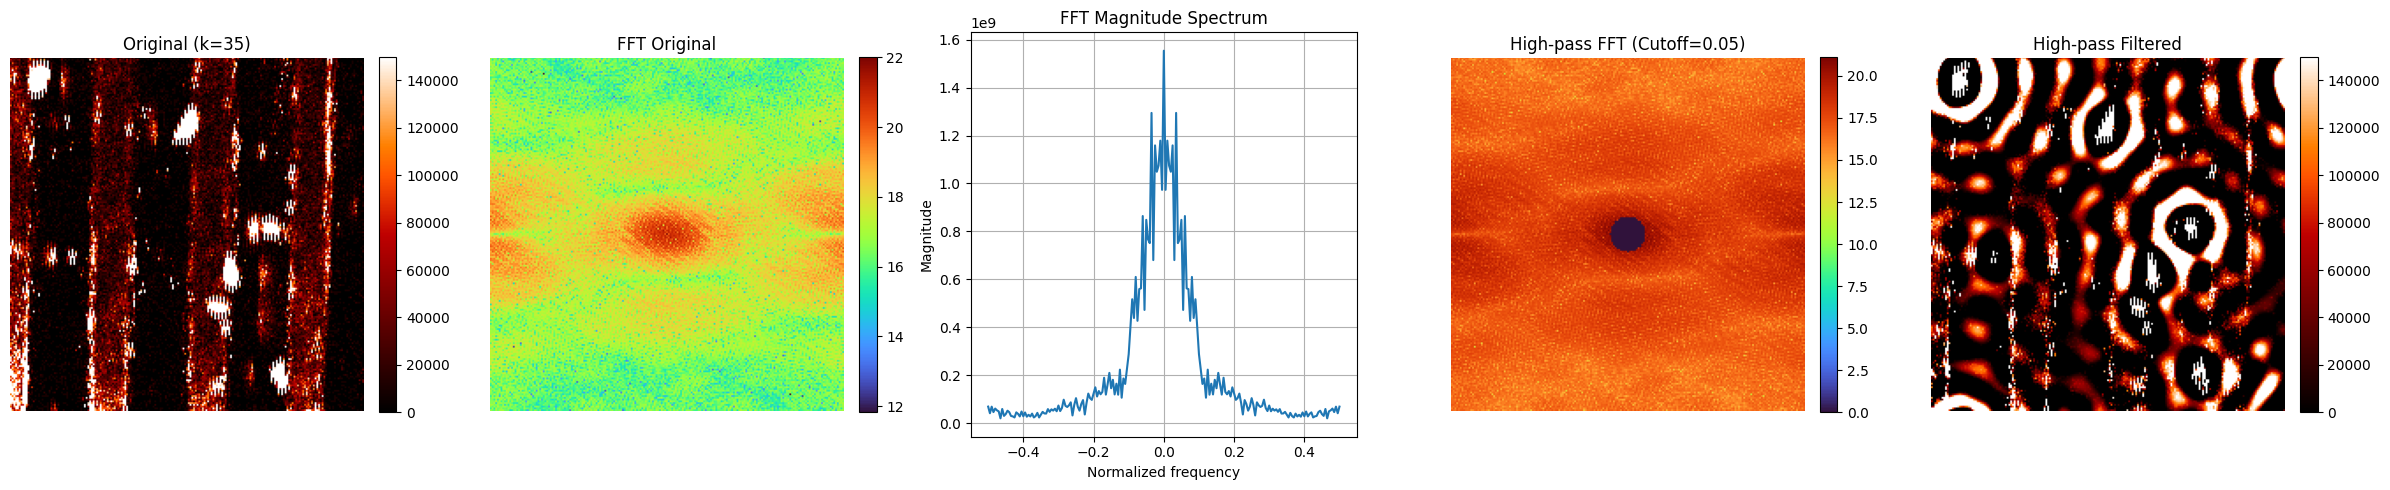

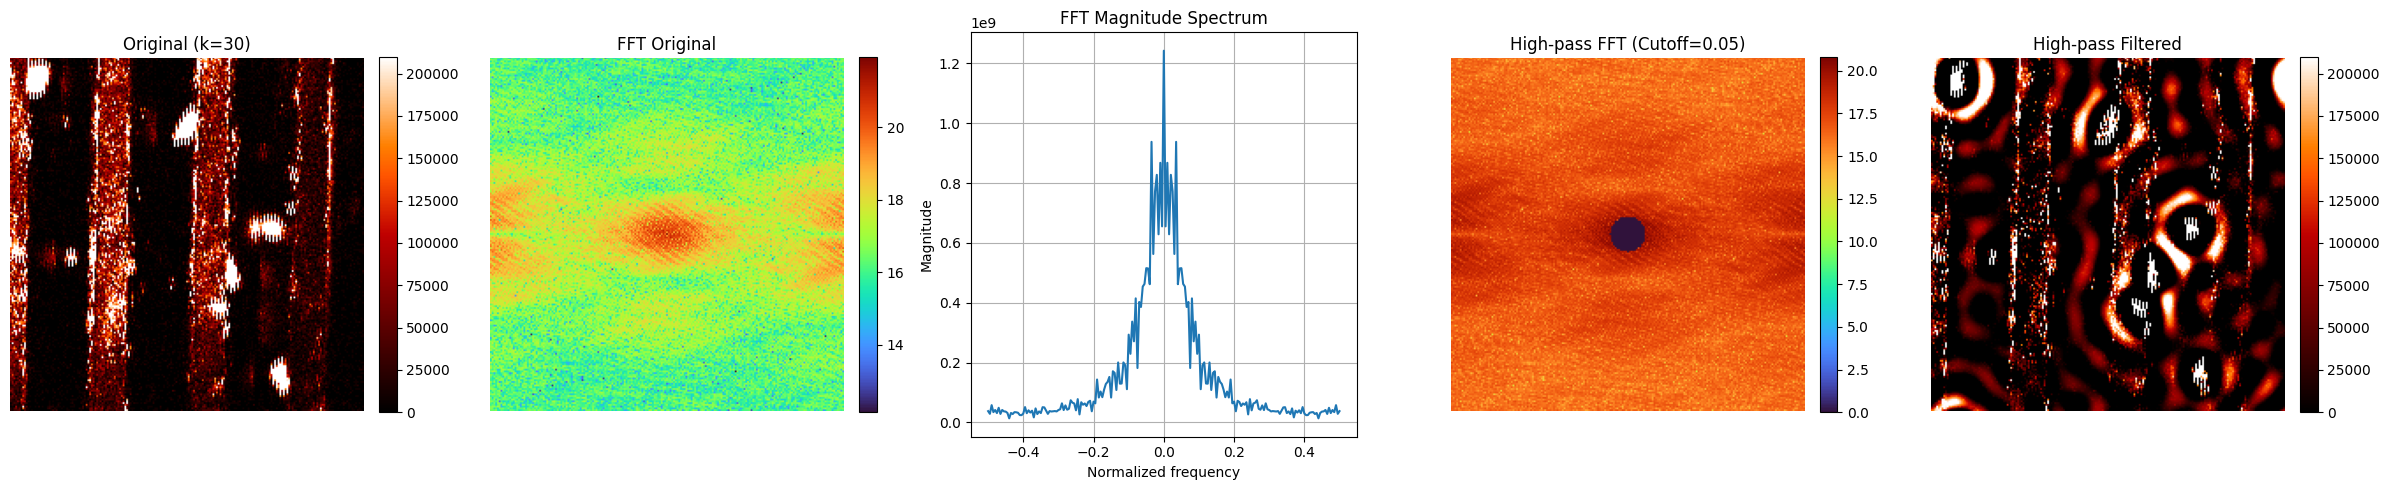

In [14]:
# =========================================
# High-pass Filter Setup
# =========================================

# 1. กำหนดค่า Cutoff Frequency
hp_cutoff = 0.05   # ปรับค่านี้เพื่อเปลี่ยนระดับการกรอง (ยิ่งมาก ยิ่งเหลือแต่ขอบ)

# 2. สร้าง High-pass mask
# เช็คว่ามีตัวแปร D (ระยะห่างจากศูนย์กลาง) หรือยัง ถ้าไม่มีให้สร้างใหม่
if 'D' not in locals():
    fy = np.linspace(-0.5, 0.5, ny)
    fx = np.linspace(-0.5, 0.5, nx)
    FX, FY = np.meshgrid(fx, fy)
    D = np.sqrt(FX**2 + FY**2)

# High-pass Logic: ให้ค่าเป็น True (1) ถ้าความถี่สูงกว่า cutoff
highpass_mask = (D >= hp_cutoff)

# 3. Apply High-pass Filter + Inverse FFT
fft_hp = np.zeros_like(fft_vol, dtype=complex)
img_hp = np.zeros_like(vol, dtype=float)

for k in range(nz):
    # คูณ Mask
    fft_hp[:, :, k] = fft_vol[:, :, k] * highpass_mask
    
    # แปลงกลับเป็นรูปภาพ
    img_hp[:, :, k] = np.real(
        np.fft.ifft2(np.fft.ifftshift(fft_hp[:, :, k]))
    )

# =========================================
# 4. Visualization Function
# =========================================
def show_slice_highpass(
    k,
    vmin=None,
    vmax=None,
    cmap_img='gist_heat',
    cmap_fft='turbo',
    cmap_filt='gist_heat'
):
    if not (0 <= k < nz):
        print(f"Slice k={k} อยู่นอกขอบเขต (0-{nz-1})")
        return

    img  = vol[:, :, k]
    F    = fft_vol[:, :, k]
    Fhp  = fft_hp[:, :, k]
    imgh = img_hp[:, :, k]

    logF   = np.log1p(np.abs(F))
    logFhp = np.log1p(np.abs(Fhp))

    # Auto contrast
    if vmin is None:
        vmin = np.percentile(img, 2)
    if vmax is None:
        vmax = np.percentile(img, 95)

    # Spectrum plot prep
    mag = np.abs(F)
    cy = ny // 2
    spectrum = mag[cy-1:cy+2, :].mean(axis=0)

    fig, axes = plt.subplots(1, 5, figsize=(24, 5))

    # 1. Original Image
    im0 = axes[0].imshow(img, cmap=cmap_img, origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original (k={k})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 2. FFT Original
    im1 = axes[1].imshow(logF, cmap=cmap_fft, origin='lower')
    axes[1].set_title('FFT Original')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 3. FFT Magnitude Spectrum
    axes[2].plot(freq_x, spectrum)
    axes[2].set_title('FFT Magnitude Spectrum')
    axes[2].set_xlabel('Normalized frequency')
    axes[2].set_ylabel('Magnitude')
    axes[2].grid(True)

    # 4. High-pass FFT
    im2 = axes[3].imshow(logFhp, cmap=cmap_fft, origin='lower')
    axes[3].set_title(f'High-pass FFT (Cutoff={hp_cutoff})')
    axes[3].axis('off')
    plt.colorbar(im2, ax=axes[3], fraction=0.046, pad=0.04)

    # 5. High-pass Filtered Image
    im3 = axes[4].imshow(imgh, cmap=cmap_filt, origin='lower', vmin=vmin, vmax=vmax)
    axes[4].set_title('High-pass Filtered')
    axes[4].axis('off')
    plt.colorbar(im3, ax=axes[4], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# =========================================
# เรียกใช้งานฟังก์ชันสำหรับหลายๆ Slice
# =========================================
print("Showing High-pass results for multiple slices...")
show_slice_highpass(k=35)
show_slice_highpass(k=30)

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- ส่วนคำนวณหาภาพที่ชัดที่สุด (Best Focus Detection) ---

def calculate_focus_score(image):
    """
    คำนวณค่า Focus Score โดยใช้ Variance of Laplacian
    ค่ามาก = ภาพมีความคมชัดสูง (High Frequency details เยอะ)
    """
    # ตรวจสอบว่าเป็นภาพสีหรือไม่ ถ้าใช่ให้แปลงเป็น Gray
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # คำนวณ Laplacian และหา Variance
    # (ต้องแปลงเป็น float เพื่อความแม่นยำในการคำนวณ)
    score = cv2.Laplacian(image, cv2.CV_64F).var()
    return score

# ตรวจสอบว่ามีตัวแปร volume หรือไม่
if 'volume' in locals():
    print(f"Processing volume with shape: {vol.shape}")
    
    nz = vol.shape[2] # จำนวน slice (แกน Z) ตามที่คุณระบุไว้
    scores = []
    
    # 1. วนลูปคำนวณคะแนนทุก Slice
    for z in range(nz):
        # ดึงภาพแต่ละ Slice ออกมา (สมมติว่า volume เก็บเป็น [x, y, z])
        current_slice = vol[:, :, z]
        
        # คำนวณคะแนน
        sc = calculate_focus_score(current_slice)
        scores.append(sc)

    # 2. หา Slice ที่มีคะแนนสูงสุด
    best_slice_idx = np.argmax(scores)
    max_score = scores[best_slice_idx]
    
    print(f"\n✅ Slice ที่ชัดที่สุดคือ: {best_slice_idx} (Score: {max_score:.2f})")

    # 3. แสดงผลกราฟ
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: กราฟคะแนน Focus
    plt.subplot(1, 2, 1)
    plt.plot(range(nz), scores, marker='o', markersize=3, color='blue', label='Focus Score')
    plt.axvline(best_slice_idx, color='red', linestyle='--', label=f'Best: Slice {best_slice_idx}')
    plt.title('Focus Score per Slice (Variance of Laplacian)')
    plt.xlabel('Slice Index (z)')
    plt.ylabel('Score (Sharpness)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: แสดงภาพที่ชัดที่สุด
    plt.subplot(1, 2, 2)
    plt.imshow(volume[:, :, best_slice_idx], cmap='gray')
    plt.title(f'Best Focus Image (Slice {best_slice_idx})\nScore: {max_score:.1f}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Error: ไม่พบตัวแปร 'volume' กรุณารัน Cell ที่โหลดข้อมูลก่อนหน้านี้ก่อน")

Error: ไม่พบตัวแปร 'volume' กรุณารัน Cell ที่โหลดข้อมูลก่อนหน้านี้ก่อน


Volume shape = (201, 201, 61)
Best Low-pass slice  = 0
Best High-pass slice = 35
Best Band-pass slice = 35


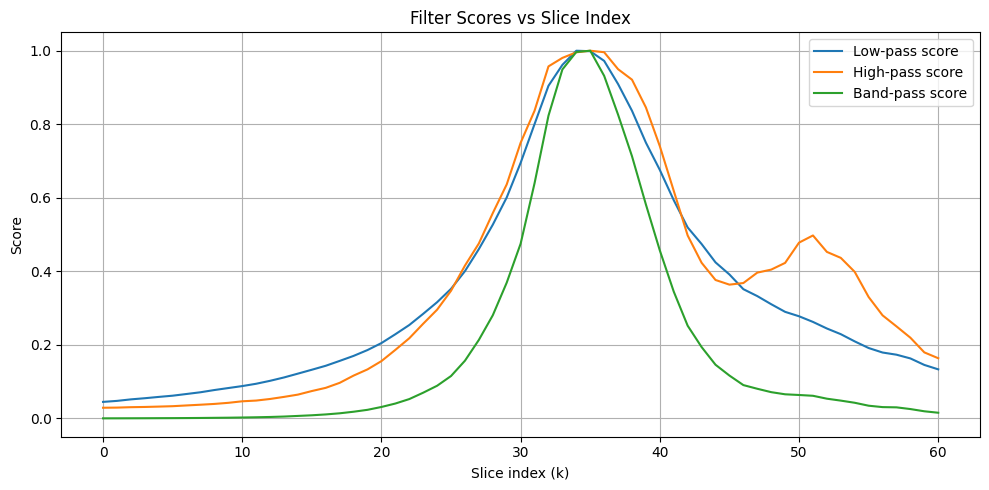

In [19]:
# =========================================
# Import
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

%matplotlib inline


# =========================================
# 1) Load .mat file (3D volume)
# =========================================
file_path = 'IMG_0191.mat'
varname   = 'pl'

mat = sio.loadmat(file_path)
vol = mat[varname]

if vol.ndim != 3:
    raise ValueError('Input must be a 3D volume')

ny, nx, nz = vol.shape
print(f'Volume shape = {vol.shape}')


# =========================================
# 2) FFT of each slice
# =========================================
fft_vol = np.zeros((ny, nx, nz), dtype=complex)

for k in range(nz):
    fft_vol[:, :, k] = np.fft.fftshift(
        np.fft.fft2(vol[:, :, k])
    )


# =========================================
# 3) Frequency grid
# =========================================
fy = np.linspace(-0.5, 0.5, ny)
fx = np.linspace(-0.5, 0.5, nx)
FX, FY = np.meshgrid(fx, fy)
D = np.sqrt(FX**2 + FY**2)


# =========================================
# 4) Define filters
# =========================================
low_cut  = 0.03
high_cut = 0.12

# Low-pass
mask_lp = D <= low_cut

# High-pass
mask_hp = D >= high_cut

# Band-pass
mask_bp = (D >= low_cut) & (D <= high_cut)


# =========================================
# 5) Apply filters + inverse FFT
# =========================================
img_lp = np.zeros_like(vol, dtype=float)
img_hp = np.zeros_like(vol, dtype=float)
img_bp = np.zeros_like(vol, dtype=float)

fft_lp = np.zeros_like(fft_vol, dtype=complex)
fft_hp = np.zeros_like(fft_vol, dtype=complex)
fft_bp = np.zeros_like(fft_vol, dtype=complex)

for k in range(nz):

    # Low-pass
    fft_lp[:, :, k] = fft_vol[:, :, k] * mask_lp
    img_lp[:, :, k] = np.real(
        np.fft.ifft2(np.fft.ifftshift(fft_lp[:, :, k]))
    )

    # High-pass
    fft_hp[:, :, k] = fft_vol[:, :, k] * mask_hp
    img_hp[:, :, k] = np.real(
        np.fft.ifft2(np.fft.ifftshift(fft_hp[:, :, k]))
    )

    # Band-pass
    fft_bp[:, :, k] = fft_vol[:, :, k] * mask_bp
    img_bp[:, :, k] = np.real(
        np.fft.ifft2(np.fft.ifftshift(fft_bp[:, :, k]))
    )


# =========================================
# 6) Compute scores for 3 filters
# =========================================
scores = {
    'k': [],
    'lowpass': [],
    'highpass': [],
    'bandpass': []
}

for k in range(nz):

    # Low-pass score: smoothness / noise reduction
    score_lp = np.std(img_lp[:, :, k])

    # High-pass score: edge / high-frequency strength
    score_hp = np.std(img_hp[:, :, k])

    # Band-pass score: energy in frequency band (MOST IMPORTANT)
    score_bp = np.sum(np.abs(fft_bp[:, :, k])**2)

    scores['k'].append(k)
    scores['lowpass'].append(score_lp)
    scores['highpass'].append(score_hp)
    scores['bandpass'].append(score_bp)


# =========================================
# 7) Find best slice for each filter
# =========================================
best_lp = scores['k'][np.argmin(scores['lowpass'])]
best_hp = scores['k'][np.argmax(scores['highpass'])]
best_bp = scores['k'][np.argmax(scores['bandpass'])]

print('Best Low-pass slice  =', best_lp)
print('Best High-pass slice =', best_hp)
print('Best Band-pass slice =', best_bp)


# =========================================
# 😎 Plot scores vs k
# =========================================
plt.figure(figsize=(10,5))
plt.plot(scores['k'], scores['lowpass']/np.max(scores['lowpass']),  label='Low-pass score')
plt.plot(scores['k'], scores['highpass']/np.max(scores['highpass']), label='High-pass score')
plt.plot(scores['k'], scores['bandpass']/np.max(scores['bandpass']), label='Band-pass score')
plt.xlabel('Slice index (k)')
plt.ylabel('Score')
plt.title('Filter Scores vs Slice Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
